# Decision Tree Regressor from Scratch
***
## Table of Contents
1. Loading Data
2. Train Test Split
3. Loss Functions for Regression
4. Information Gain
5. Identifying the Best Split
6. Building the Decision Tree
7. Traversing the Tree for Prediction
8. Evaluation Metrics
9. Predictions
10. Model Evaluation
11. Model Encapsulation
12. Comparison with Scikit-Learn
***

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict
from numpy.typing import NDArray

Decision trees and regression trees are collectively referred to as **CART**, which stands for **Classification and Regression Trees**.

- **Decision Trees** are used for classification tasks, where the target variable is *categorical*.

- **Regression Trees** are used for regression tasks, where the target variable is *continuous*.

CART is a popular algorithm that can handle both types of tasks by optimising for different criteria:

- For classification, CART minimises classification error, Gini impurity, or entropy.

- For regression, CART minimises the variance, mean squared error (MSE) or mean absolute error (MAE).

Both types of trees follow the same core idea of splitting the data based on conditions to create homogeneous subsets, but their objectives differ depending on the problem type.
In this notebook, we will build a predictive model using Regression Trees on the admission chance dataset from YBI Foundation's GitHub repository.

### 1. Structure

- **Nodes**: Represent features or decisions.

- **Edges**: Represent conditions or thresholds.

- **Leaves**: Represent outcomes or class labels (in classification) or predicted values (in regression).

### 2. Construction

- Begins with the root node (the entire dataset).

- Splits the data based on feature thresholds that maximise the information gain (derived from Gini impurity, entropy, MSE or variance reduction).

- Recursively continues until a stopping condition is met (e.g., maximum depth, minimum samples per leaf, or pure nodes).

### 3. Advantages

- Intuitive and easy to interpret.

- Handles both numerical and categorical data.

- Non-parametric and robust to outliers.

### 4. Limitations

- Prone to overfitting, especially with deep trees.

- Sensitive to slight changes in the data (high variance).

## 1. Loading Data
Retrieved from [GitHub - YBI Foundation](https://github.com/YBI-Foundation/Dataset/blob/main/Admission%20Chance.csv)

In [2]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/YBI-Foundation/Dataset/refs/heads/main/Admission%20Chance.csv')
df.head()

,Serial No,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()
feature_names = df.columns[:-1].tolist()  # All columns except the last one

# Check the shape of the data
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Features: \n{feature_names}")

Features shape: (400, 8)
Target shape: (400,)
Features: 
['Serial No', 'GRE Score', 'TOEFL Score', 'University Rating', ' SOP', 'LOR ', 'CGPA', 'Research']


## 2. Train Test Split
Train test split is a fundamental model validation technique in machine learning. It divides a dataset into two separate portions: a **training set** used to train a model, and a **testing set** used to evaluate how well the model can perform on unseen data. 

The typical split ratio is 80% for training and 20% for testing, though this can vary (70/30 or 90/10 are also common). The key principle is that the test set must remain completely separated during model training process, and should never be used to make decisions about the model or tune parameters. 

The split is usually done randomly to ensure both sets are representative of the overall dataset, and many libraries (such as scikit-learn) provide build-in functions that handle this process automatically while maintaining proper randomisation.


In [4]:
def train_test_split(X: NDArray, y: NDArray, test_size: float = 0.2,
                     random_state: int = None) -> Tuple[NDArray, NDArray, NDArray, NDArray]:
    """
    Split arrays or matrices into random train and test subsets.

    Args:
        X (NDArray): Input features, a 2D array with rows (samples) and columns (features).
        y (NDArray): Target values/labels, a 1D array with rows (samples).
        test_size (float): Proportion of the dataset to include in the test split. Must be between 0.0 and 1.0. default = 0.2
        random_state (int): Seed for the random number generator to ensure reproducible results. default = None

    Returns:
        Tuple[NDArray, NDArray, NDArray, NDArray]:
        A tuple containing:
            - X_train (NDArray): Training set features.
            - X_test (NDArray): Testing set features.
            - y_train (NDArray): Training set target values.
            - y_test (NDArray): Testing set target values.
    """
    # Set a random seed if it exists
    if random_state:
        np.random.seed(random_state)

    # Create a list of numbers from 0 to len(X)
    indices = np.arange(len(X))

    # Shuffle the indices
    np.random.shuffle(indices)

    # Define the size of our test data from len(X)
    test_size = int(test_size * len(X))

    # Generate indices for test and train data
    test_indices: NDArray[np.int64] = indices[:test_size]
    train_indices: NDArray[np.int64] = indices[test_size:]

    # Return: X_train, X_test, y_train, y_test
    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

## 3. Loss Functions for Regression
### Variance

In [5]:
def variance(y: NDArray[np.float64]) -> float:
    return np.var(y)

### Mean Squared Error (MSE)

In [6]:
def mse(y: NDArray[np.float64]) -> float:
    mean = np.mean(y)
    return np.mean((y - mean) ** 2)

In [7]:
print(f"Variance: {variance(y):.5f}")
print(f"MSE: {mse(y):.5f}")

Variance: 0.02029
MSE: 0.02029


## 4. Information Gain
Information Gain is a metric used to measure the effectiveness of a feature in splitting a dataset into subsets that are more pure concerning the target variable. It quantifies the reduction in variance or MSE, and a higher information gain indicates a better feature for making splits.

\begin{align*}
IG(S, A) = H(S) - \sum_{i=1}^{n} \dfrac{|S_i|}{|S|}H(S_{i})
\end{align*}

where:
- $H(S)$: Variance (or MSE) of the original dataset $S$.
- $S_{i}$: Subset of $S$ created by splitting on feature $A$ for the $i_{th}$ value or range of the feature.
- $\dfrac{|S_i|}{|S|}$: Proportion of samples in subset $S_{i}$.
- $H(S_{i})$: Variance (or MSE) of subset $S_{i}$.



The following `information_gain` function calculates the difference between the metric for the parent node and the weighted average of the metrics for the child nodes (left and right splits).

In [8]:
def information_gain(y: NDArray[np.float64], y_left: NDArray[np.float64], y_right: NDArray[np.float64],
                     metric: str = "variance") -> float:
    """
    Calculate the information gain for regression.

    Args:
        y (NDArray[np.float64]): Target variables of the parent node.
        y_left (NDArray[np.float64]): Target variables of the left child node after the split.
        y_right (NDArray[np.float64]): Target variables of the right child node after the split.
        metric (str, optional): Splitting criterion, either "variance" or "mse". Defaults to "variance".

    Returns:
        float: Information gain resulting from the split.
    """
    if metric == "variance":
        parent_metric = variance(y)
        left_metric = variance(y_left)
        right_metric = variance(y_right)
    else:  # metric == "mse"
        parent_metric = mse(y)
        left_metric = mse(y_left)
        right_metric = mse(y_right)

    weighted_metric = (
        len(y_left) / len(y) * left_metric
        + len(y_right) / len(y) * right_metric
    )
    return parent_metric - weighted_metric

## 5. Identifying the Best Split
This function identifies the best feature and threshold to split the data using the specified metric (Variance or MSE).

Steps are:

1. Loop through all features.

2. For each feature, iterate over all unique thresholds.

3. Split the data into left and right subsets based on the threshold (skip invalid ones).

4. Compute the Gini/Entropy for both subsets and calculate Information Gain.

5. If the newly computed `info_gain` > `best_info_gain`, then update `best_info_gain` with the new information.

In [9]:
def best_split(X: NDArray[np.float64], y: NDArray[np.float64], metric: str = "variance",
               feature_names: List[str | int] = None) -> Dict[str, int | str | np.float64]:
    """
    Find the best split for a dataset for regression.

    Args:
        X (NDArray[np.float64]): Input features (2D array of shape [n_samples, n_features]).
        y (NDArray[np.float64]): Target variables (1D array of shape [n_samples]).
        metric (str, optional): Splitting criterion, either "variance" or "mse". Defaults to "variance".
        feature_names (List[str|int], optional): List of feature names. If None, indices are used. Defaults to None.

    Returns:
        dict: Dictionary containing the best split with keys:
              - 'feature_index' (int): Index of the feature used for the split.
              - 'feature_name' (str/int): Name or index of the feature.
              - 'threshold' (float): Threshold value for the split.
    """
    best_info_gain = float("-inf")
    best_split = None
    n_features = X.shape[1]

    # Iterate over all features.
    for feature in range(n_features):
        # Iterate over all unique thresholds for each feature.
        thresholds = np.unique(X[:, feature])
        for threshold in thresholds:
            # Split the data into left and right subsets based on the threshold.
            left_mask = X[:, feature] <= threshold
            right_mask = X[:, feature] > threshold

            # Skip invalid splits.
            if sum(left_mask) == 0 or sum(right_mask) == 0:
                continue

            # Compute information gain.
            info_gain = information_gain(
                y, y[left_mask], y[right_mask], metric)

            # Update `best_info_gain` if `info_gain` > `best_info_gain`.
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_split = {
                    "feature_index": feature,
                    "feature_name": feature_names[feature] if feature_names is not None else feature,
                    "threshold": threshold,
                }

    return best_split

In [10]:
split = best_split(X, y, metric="variance", feature_names=feature_names)
print("Best Split:", split)

Best Split: {'feature_index': 6, 'feature_name': 'CGPA', 'threshold': np.float64(8.73)}


## 6. Building the Decision Tree
This function resursively creates the tree structure as a nested dictionary with conditions (`feature` and `threshold`) and leaf nodes.

In [11]:
def build_tree(X: NDArray[np.float64], y: NDArray[np.float64], max_depth: int = None,
               depth: int = 0, metric: str = "variance",
               feature_names: List[str | int] = None) -> Dict[
        str, str | int | float | np.float64 | Dict]:
    """
    Build a decision tree for regression using recursive splitting.

    Args:
        X (NDArray[np.float64]): Input features (2D array of shape [n_samples, n_features]).
        y (NDArray[np.float64]): Target variables (1D array of shape [n_samples]).
        max_depth (int, optional): Maximum depth of the tree. Defaults to None (unlimited depth).
        depth (int, optional): Current depth of the tree. Used internally for recursion. Defaults to 0.
        metric (str, optional): Splitting criterion, either "variance" or "mse". Defaults to "variance".
        feature_names (List[str|int], optional): List of feature names. If None, indices are used. Defaults to None.

    Returns:
        dict: Nested dictionary representing the tree structure.
              Nodes contain keys: 'type', 'feature', 'threshold', 'left', 'right'.
              Leaf nodes contain keys: 'type', 'value'.
    """
    # Stop the recursion if maximum depth is reached or data cannot be split further.
    if len(set(y)) == 1 or (max_depth is not None and depth == max_depth):
        return {"type": "leaf", "value": round(float(np.mean(y)), 4)}

    # Find the best split.
    split = best_split(X, y, metric, feature_names)
    if not split:
        return {"type": "leaf", "value": round(float(np.mean(y)), 4)}

    # Split the data into left and right subsets.
    left_mask = X[:, split["feature_index"]] <= split["threshold"]
    right_mask = X[:, split["feature_index"]] > split["threshold"]

    # Recursively build the left and right subtrees.
    left_tree = build_tree(X[left_mask], y[left_mask],
                           max_depth, depth + 1, metric, feature_names)
    right_tree = build_tree(X[right_mask], y[right_mask],
                            max_depth, depth + 1, metric, feature_names)

    # Return the tree structure as a nested dictionary.
    return {
        "type": "node",
        "feature": split["feature_name"],
        "threshold": round(float(split["threshold"]), 4),
        "left": left_tree,
        "right": right_tree,
    }

## 7. Traversing the Tree For Prediction
This function traverses the tree to make predictions by following the tree from the root to a leaf node.

In [12]:
def traverse_tree(x: NDArray[np.float64], tree: Dict[str, str | int | float | np.float64 | Dict],
                  feature_names: List[str | int] = None) -> float:
    """
    Traverse a decision tree to make a prediction for a single sample.

    Args:
        x (NDArray[np.float64]): Single sample (1D array of features).
        tree (Dict[str, str | int | float | np.float64 | Dict]): Decision tree structure.
        feature_names (List[str | int], optional): List of feature names. Needed for name-to-index mapping. Defaults to None.

    Returns:
        float: Predicted value.
    """
    if tree["type"] == "leaf":
        return tree["value"]

    # Resolve feature index if feature_names is provided
    feature_index = feature_names.index(
        tree["feature"]) if feature_names is not None else tree["feature"]

    if x[feature_index] <= tree["threshold"]:
        return traverse_tree(x, tree["left"], feature_names)
    else:
        return traverse_tree(x, tree["right"], feature_names)

## 8. Evaluation Metrics
### 1. Mean Squared Error (MSE)
Mean Squared Error measures the average squared difference between predicted ($\hat y$) and actual ($y$) values. Large errors are penalised heavily. Smaller MSE indicates better predictions.

\begin{align*}
MSE = \dfrac{1}{n} \sum_{i=1}^{n}(\hat y_{i} = y_{i})^2
\end{align*}

In [13]:
def calculate_MSE(y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
    return np.mean((y_true - y_pred) ** 2)

### 2. Root Mean Squared Error (RMSE)
Square root of MSE. It provides error in the same unit as the target variable ($y$) and easier to interpret.

\begin{align*}
RMSE = \sqrt{(MSE)}
\end{align*}

In [14]:
def calculate_RMSE(y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

### 3. Mean Absolute Error (MAE)
Mean Absolute Error measures the average absolute difference between predicted ($\hat y$) and actual ($y$) values. It is less sensitive to outliers than MSE. Smaller MAE indicates better predictions.

\begin{align*}
MAE = \dfrac{1}{n} \sum_{i=1}^{n}|\hat y_{i} = y_{i}|
\end{align*}

In [15]:
def calculate_MAE(y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
    return np.mean(np.abs(y_true - y_pred))

### 4. R-squared($R^2$)

R-squared indicated the proportion of variance in the dependent variable that is predictable from the independent variables. Value ranges from 0 to 1. Closer to 1 indicates a better fit.



Residual Sum of Squares ($SS_{residual}$): 
\begin{align*}
SS_{residual} = \sum_{i=1}^{n} (y_{i} - \hat y_{i})^{2}
\end{align*}

Total Sum of Squares ($SS_{total}$): 
\begin{align*}
SS_{total} = \sum_{i=1}^{n} (y_{i} - \bar y_{i})^{2}
\end{align*}

$R^2$ is computed as:

\begin{align*}

R^2 = 1 - \dfrac{SS_{residual}}{SS_{total}} = 1 - \dfrac{\sum_{i=1}^{n} (y_{i} - \hat y_{i})^{2}}{\sum_{i=1}^{n} (y_{i} - \bar y_{i})^{2}}

\end{align*}

where:

$y$: Actual target values.

$\bar y$: Mean of the actual target values.

$\hat y$: Precicted target values.

In [16]:
def calculate_r2(y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

## 9. Predictions
This function predicts values for all samples in the dataset.

In [17]:
def predict(X: NDArray[np.float64], tree: Dict[str, str | int | float | np.float64 | Dict], feature_names: List[str | int] = None) -> NDArray[np.float64]:
    """
    Predict labels for the given dataset using a decision tree classifier.

    Args:
        X (NDArray[np.float64]): Input features (2D array for multiple samples or 1D array for a single sample).
        tree (Dict[str, str | int | float | np.float64 | Dict]): Decision tree structure.
        feature_names (List[str | int], optional): List of feature names. Needed for name-to-index mapping. Defaults to None.

    Returns:
        NDArray[np.float64]: Predicted values (1D array for multiple samples or a single label for one sample).
    """
    if len(X.shape) == 1:  # If a single sample is provided
        return traverse_tree(X, tree, feature_names)
    return np.array([traverse_tree(x, tree, feature_names) for x in X])

In [18]:
# Load the dataset
import pprint

# Build the tree using variance
tree_var = build_tree(X, y, max_depth=3, metric="variance",
                      feature_names=feature_names)

# Display the tree
pprint.pprint(tree_var)

{'feature': 'CGPA',
 'left': {'feature': 'CGPA',
          'left': {'feature': 'CGPA',
                   'left': {'type': 'leaf', 'value': 0.4821},
                   'right': {'type': 'leaf', 'value': 0.5789},
                   'threshold': 7.66,
                   'type': 'node'},
          'right': {'feature': 'Serial No',
                    'left': {'type': 'leaf', 'value': 0.6266},
                    'right': {'type': 'leaf', 'value': 0.7071},
                    'threshold': 126.0,
                    'type': 'node'},
          'threshold': 8.03,
          'type': 'node'},
 'right': {'feature': 'CGPA',
           'left': {'feature': 'CGPA',
                    'left': {'type': 'leaf', 'value': 0.7705},
                    'right': {'type': 'leaf', 'value': 0.8449},
                    'threshold': 9.05,
                    'type': 'node'},
           'right': {'feature': 'CGPA',
                     'left': {'type': 'leaf', 'value': 0.9097},
                     'right': {'ty

## 10. Model Evaluation

In [19]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Build the tree on training data
tree_var = build_tree(X_train, y_train, max_depth=3,
                      metric="variance", feature_names=feature_names)

# Predict on the test set
y_pred = predict(X_test, tree_var, feature_names=feature_names)

# Calculate R2 score
test_r2 = calculate_r2(y_test, y_pred)
print("Test R2 score:", test_r2)

# Predict a single sample
single_sample = X_test[0]
single_prediction = predict(
    single_sample, tree_var, feature_names=feature_names)
print("Predicted label for single sample:", single_prediction)
print("Actual label for single sample:", y_test[0])

Test R2 score: 0.7720114438982959
Predicted label for single sample: 0.7134
Actual label for single sample: 0.68


## 11. Model Encapsulation

To encapsulate the codes above, it will be a better idea to divide them into two different classes:
1. `CustomDecisionTreeRegressor` containing the core logic for building, traversing and predicting using the decision tree.
2. `Node` representing a single node in the decision tree, either internal node or leaf node.

In [20]:
class Node:
    """
    A class representing a node in the decision tree.

    Attributes:
        type (str): Type of the node ("leaf" or "node").
        value (int or None): Predicted label for leaf nodes. None for internal nodes.
        feature (int or None): Index of the feature for internal nodes. None for leaf nodes.
        threshold (float or None): Threshold value for internal nodes. None for leaf nodes.
        left (Node or None): Left child node. None for leaf nodes.
        right (Node or None): Right child node. None for leaf nodes.
    """

    def __init__(self, type: str, value: float = None,
                 feature: int = None, threshold: float = None, left: 'Node' = None, right: 'Node' = None):
        """
        Initialise a Node instance.

        Args:
            type (str): Type of the node ("leaf" or "node").
            value (float or None): Predicted label for leaf nodes. None for internal nodes.
            feature (int or None): Index of the feature for internal nodes. None for leaf nodes.
            threshold (float or None): Threshold value for internal nodes. None for leaf nodes.
            left (Node or None): Left child node. None for leaf nodes.
            right (Node or None): Right child node. None for leaf nodes.
        """
        self.type = type  # "leaf" or "node"
        self.value = value  # For leaf nodes
        self.feature = feature  # For internal nodes
        self.threshold = threshold  # For internal nodes
        self.left = left  # Left child
        self.right = right  # Right child

In [21]:
class CustomDecisionTreeRegressor:
    """
    A class representing a decision tree regressor.

    Attributes:
        max_depth (int or None): Maximum depth of the tree. None for unlimited depth.
        metric (str): Splitting criterion, either "variance" or "mse".
        root (dict): Root node of the decision tree.
        feature_names (list[str] or None): List of feature names. None if not provided.
        min_variance (float): Minimum variance to continue splitting.
        min_samples_split (int): Minimum number of samples required to split a node.
    """

    def __init__(self, max_depth: int = None, metric: str = 'variance',
                 min_variance: float = 1e-7, min_sample_split: int = 2):
        """
        Initialise a CustomDecisionTreeRegressor instance.

        Args:
            max_depth (int or None): Maximum depth of the tree. None for unlimited depth.
            metric (str): Splitting criterion, either "variance" or "mse".
            min_variance (float): Minimum variance to continue splitting.
            min_sample_split (int): Minimum number of samples required to split a node.
        """
        self.max_depth = max_depth
        self.metric = metric
        self.root = None
        self.feature_names = None
        self.min_variance = min_variance
        self.min_sample_split = min_sample_split

    def variance(self, y: NDArray[np.float64]) -> float:
        """
        Calculate the variance.

        Args:
            y (NDArray[np.float64]): Array of values.

        Returns:
            float: Variance value.
        """
        return np.var(y) if len(y) > 0 else 0

    def mse(self, y: NDArray[np.float64]) -> float:
        """
        Calculate the mean squared error.

        Args:
            y (NDArray[np.float64]): Array of values.

        Returns:
            float: Mean squared error value.
        """
        return np.mean((y - np.mean(y)) ** 2) if len(y) > 0 else 0

    def information_gain(self, y: NDArray[np.float64], y_left: NDArray[np.float64], y_right: NDArray[np.float64]) -> float:
        """
        Compute the information gain of a split.

        Args:
            y (NDArray[np.float64]): Values of the parent node.
            y_left (NDArray[np.float64]): Values of the left child node.
            y_right (NDArray[np.float64]): Values of the right child node.

        Returns:
            float: Information gain from the split.
        """
        if self.metric == "variance":
            parent_metric = self.variance(y)
            left_metric = self.variance(y_left)
            right_metric = self.variance(y_right)
        else:  # metric == "mse"
            parent_metric = self.mse(y)
            left_metric = self.mse(y_left)
            right_metric = self.mse(y_right)

        weighted_metric = (
            len(y_left) / len(y) * left_metric
            + len(y_right) / len(y) * right_metric
        )
        return parent_metric - weighted_metric

    def best_split(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> Dict[int, np.float64]:
        """
        Find the best feature and threshold to split the dataset.

        Args:
            X (NDArray[np.float64]): Input features.
            y (NDArray[np.float64]): Target values as float.

        Returns:
            Dict[int, np.float64]: Best split details with keys 'feature_index' and 'threshold'.
        """
        best_info_gain = float("-inf")
        best_split: Dict = None
        n_features: int = X.shape[1]

        for feature in range(n_features):
            thresholds: NDArray[np.float64] = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask: NDArray[np.bool] = X[:, feature] <= threshold
                right_mask: NDArray[np.bool] = X[:, feature] > threshold

                if sum(left_mask) == 0 or sum(right_mask) == 0:
                    continue

                info_gain: float = self.information_gain(
                    y, y[left_mask], y[right_mask])

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_split = {
                        "feature_index": feature,
                        "threshold": threshold,
                    }

        return best_split

    def build_tree(self, X: NDArray[np.float64], y: NDArray[np.float64], depth: int = 0) -> Node:
        """
        Build the decision tree recursively.

        Args:
            X (NDArray[np.float64]): Input features.
            y (NDArray[np.float64]): Target variables as float.
            depth (int): Current depth of the tree.

        Returns:
            Node: Root node of the decision tree.
        """
        if (
            len(y) < self.min_sample_split or
            (self.max_depth is not None and depth == self.max_depth) or
            np.var(y) <= self.min_variance
        ):
            return Node(type="leaf", value=round(float(np.mean(y)), 4))

        split = self.best_split(X, y)
        if not split:
            return Node(type="leaf", value=round(float(np.mean(y)), 4))

        # Split the data
        left_mask: NDArray[np.bool] = X[:,
                                        split["feature_index"]] <= split["threshold"]
        right_mask: NDArray[np.bool] = X[:,
                                         split["feature_index"]] > split["threshold"]

        # Recursively build the left and right subtrees
        left_tree: Node = self.build_tree(
            X[left_mask], y[left_mask], depth + 1)
        right_tree: Node = self.build_tree(
            X[right_mask], y[right_mask], depth + 1)

        # Store the feature index directly for easier traversal
        feature_index: int = split["feature_index"]
        return Node(type="node", feature=feature_index, threshold=split["threshold"], left=left_tree, right=right_tree)

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64], feature_names: NDArray[np.str_] = None) -> None:
        """
        Fit the decision tree regressor to the given data.

        Args:
            X (NDArray[np.float64]): Input features.
            y (NDArray[np.float64]): Target values.
            feature_names (NDArray[np.str_], optional): Names of the features. Defaults to None.
        """
        self.feature_names = feature_names
        self.root = self.build_tree(X, y)

    def traverse_tree(self, x: NDArray[np.float64], node: Node) -> float:
        """
        Traverse the decision tree to make a prediction for a single sample.

        Args:
            x (NDArray[np.float64]): Single sample.
            node (Node): Current node.

        Returns:
            float: Predicted value.
        """
        if node.type == "leaf":
            return node.value

        feature_index = node.feature
        if x[feature_index] <= node.threshold:
            return self.traverse_tree(x, node.left)
        else:
            return self.traverse_tree(x, node.right)

    def predict(self, X: NDArray[np.float64]) -> float | NDArray[np.float64]:
        """
        Predict values for the given dataset.

        Args:
            X (NDArray[np.float64]): Input features.

        Returns:
            float or NDArray[np.float64]: Predicted value(s).
        """
        if len(X.shape) == 1:
            return self.traverse_tree(X, self.root)
        return np.array([self.traverse_tree(x, self.root) for x in X])

    def calculate_MSE(self, y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
        """
        Calculate the Mean Squared Error (MSE).

        Args:
            y_true (NDArray[np.float64]): Array of true values.
            y_pred (NDArray[np.float64]): Array of predicted values.

        Returns:
            float: The mean squared error, a measure of the average squared difference between true and predicted values.
        """
        return np.mean((y_true - y_pred) ** 2)

    def calculate_RMSE(self, y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
        """
        Calculate the Root Mean Squared Error (RMSE).

        Args:
            y_true (NDArray[np.float64]): Array of true values.
            y_pred (NDArray[np.float64]): Array of predicted values.

        Returns:
            float: The root mean squared error, providing a standard deviation-like measure of prediction errors.
        """
        return np.sqrt(np.mean((y_true - y_pred) ** 2))

    def calculate_MAE(self, y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
        """
        Calculate the Mean Absolute Error (MAE).

        Args:
            y_true (NDArray[np.float64]): Array of true values.
            y_pred (NDArray[np.float64]): Array of predicted values.

        Returns:
            float: The mean absolute error, representing the average magnitude 
                of prediction errors without considering direction.
        """
        return np.mean(np.abs(y_true - y_pred))

    def calculate_r2(self, y_true: NDArray[np.float64], y_pred: NDArray[np.float64]) -> float:
        """
        Calculate the R-squared (coefficient of determination).

        Args:
            y_true (NDArray[np.float64]): Array of true values.
            y_pred (NDArray[np.float64]): Array of predicted values.

        Returns:
            float: The R-squared value, indicating the proportion of variance in 
                the dependent variable explained by the independent variable(s).
        """
        ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
        ss_residual = np.sum((y_true - y_pred) ** 2)
        r2 = 1 - (ss_residual / ss_total)
        return r2

    def print_tree(self, node: Node = None, depth: int = 0, prefix: str = "Root: ") -> None:
        """
        Print the tree structure in a readable format.

        Args:
            node (Node, optional): Current node. Defaults to the root node.
            depth (int, optional): Current depth. Defaults to 0.
            prefix (str, optional): Prefix for the current node. Defaults to "Root: ".
        """
        if node is None:
            node = self.root

        if node.type == "leaf":
            print("  " * depth + prefix + f"Predict -> {node.value:.4f}")
        else:
            feature_name = self.feature_names[node.feature
                                              ] if self.feature_names is not None else f"Feature_{node.feature}"
            print("  " * depth + prefix +
                  f"{feature_name} <= {node.threshold:.4f}")
            self.print_tree(node.left, depth + 1, "├─ True: ")
            self.print_tree(node.right, depth + 1, "└─ False: ")

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Train the decision tree
tree = CustomDecisionTreeRegressor(max_depth=3, metric="variance")
tree.fit(X_train, y_train, feature_names=feature_names)

# Predict and evaluate
y_pred = tree.predict(X_test)
mse_custom = tree.calculate_MSE(y_test, y_pred)
rmse_custom = tree.calculate_RMSE(y_test, y_pred)
mae_custom = tree.calculate_MAE(y_test, y_pred)
r2_custom = tree.calculate_r2(y_test, y_pred)
print(f"MSE (Custom): {mse_custom:.4f}")
print(f"RMSE (Custom): {rmse_custom:.4f}")
print(f"MAE (Custom): {mae_custom:.4f}")
print(f"R-Squared (Custom): {r2_custom:.4f}")
print("----------")

# Single prediction
sample = X_test[0]
single_prediction = tree.predict(sample)
print(
    f"Predicted: {single_prediction:.4f}, Actual: {y_test[0]:.4f}")
print("----------")

# Print the tree structure
print("\nDecision Tree Structure:")
tree.print_tree()

MSE (Custom): 0.0052
RMSE (Custom): 0.0720
MAE (Custom): 0.0520
R-Squared (Custom): 0.7720
----------
Predicted: 0.7134, Actual: 0.6800
----------

Decision Tree Structure:
Root: CGPA <= 8.7300
  ├─ True: CGPA <= 8.0300
    ├─ True: GRE Score <= 308.0000
      ├─ True: Predict -> 0.5206
      └─ False: Predict -> 0.6176
    └─ False: Serial No <= 126.0000
      ├─ True: Predict -> 0.6296
      └─ False: Predict -> 0.7134
  └─ False: CGPA <= 9.2200
    ├─ True: CGPA <= 8.9200
      ├─ True: Predict -> 0.7581
      └─ False: Predict -> 0.8274
    └─ False: CGPA <= 9.4600
      ├─ True: Predict -> 0.9132
      └─ False: Predict -> 0.9489


## 12. Comparison with Scikit-Learn

MSE (SK): 0.0046
MSE (Custom): 0.0052
----------
RMSE (SK): 0.0677
RMSE (Custom): 0.0720
----------
MAE (SK): 0.0498
MAE (Custom): 0.0520
----------
R-Squared (SK): 0.7987
R-Squared (Custom): 0.7720


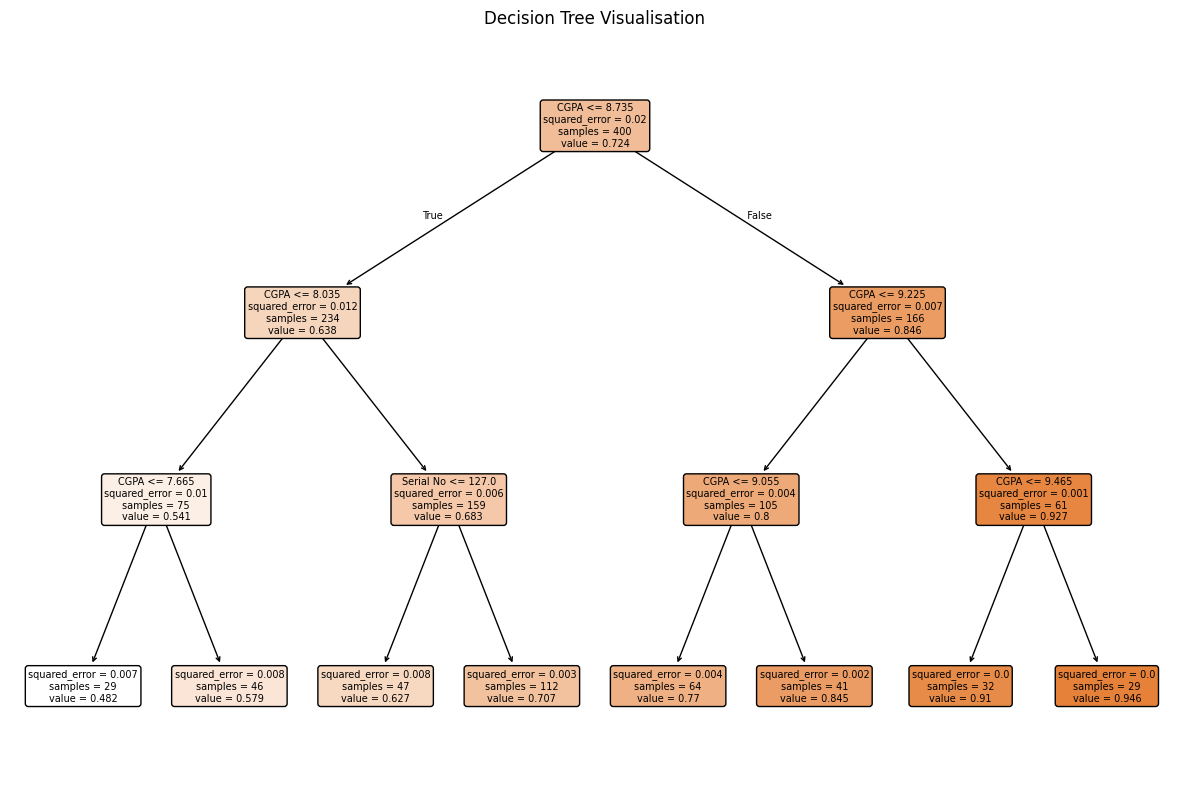

In [23]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

regressor = DecisionTreeRegressor(
    max_depth=3
)
regressor.fit(X, y)

# Predict and evaluate
y_pred = regressor.predict(X_test)
mse_sk = mean_squared_error(y_test, y_pred)
rmse_sk = np.sqrt(mse_sk)
mae_sk = mean_absolute_error(y_test, y_pred)
r2_sk = r2_score(y_test, y_pred)

print(f"MSE (SK): {mse_sk:.4f}")
print(f"MSE (Custom): {mse_custom:.4f}")
print("----------")
print(f"RMSE (SK): {rmse_sk:.4f}")
print(f"RMSE (Custom): {rmse_custom:.4f}")
print("----------")
print(f"MAE (SK): {mae_sk:.4f}")
print(f"MAE (Custom): {mae_custom:.4f}")
print("----------")
print(f"R-Squared (SK): {r2_sk:.4f}")
print(f"R-Squared (Custom): {r2_custom:.4f}")


# Visualise the decision tree
plt.figure(figsize=(12, 8))
plot_tree(
    regressor,
    feature_names=feature_names,
    filled=True,
    rounded=True
)
plt.title("Decision Tree Visualisation")
plt.tight_layout()
plt.show()